In [110]:
from google.colab import drive
drive.mount('/content/gdrive')
import requests
import yaml
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [111]:
print("PyTorch version:", torch.__version__)

PyTorch version: 1.1.0


In [0]:
"""
Basic multilayer perceptron subclass 
of three layers in PyTorch
"""
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1 = nn.Linear(in_features=5,out_features=32)
        self.fc2 = nn.Linear(in_features=32,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=1)
    
    def forward(self, x):
        """"Forward pass definition"""
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return x

In [0]:
class TickerData(torch.utils.data.Dataset):
    def __init__(self, table):
        self.dataset = table
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        """idx --> data pointer"""
        return self.dataset[idx]

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [0]:
def fetch_btc_prices():
    with open("/content/gdrive/My Drive/College/Undergraduate Research/StockData/BTC_data.json") as f:
        return json.load(f)

def parse_alphaV_JSON(raw_data):
    # Remove meta data for now
    raw_data.pop('Meta Data',None)
    # Remove key name
    df = pd.DataFrame.from_dict(raw_data['Time Series (Digital Currency Daily)'],dtype=float)
    # Flip dates as columns into rows
    df = df.transpose()
    return df

def normalize():
    pass


def data_split(x_train,y_train):
        x_train, x_test, y_train, y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=100,shuffle=False)
        return x_train, x_test, y_train, y_test

def train(model, x_data,y_data, original_prices):

    prices = torch.tensor(original_prices)
    max_price = torch.max(prices)
    min_price = torch.min(prices)

    print('----Dataset Prep----')
    x_train, x_test, y_train, y_test = data_split(x_data,y_data)
    train_tensorDataset = torch.utils.data.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train))
    train_data_loader = torch.utils.data.DataLoader(
        dataset=train_tensorDataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    test_tensorDataset = torch.utils.data.TensorDataset(torch.Tensor(x_test),torch.Tensor(y_test))
    test_data_loader = torch.utils.data.DataLoader(
        dataset=test_tensorDataset,
        batch_size=1,
        shuffle=False,
        num_workers=0
    )

    print('-- Model Architecture --')
    print(model)
    
    # -- Model to CUDA GPU --
    #model.to(device)

    # -- Since we are predicting prices --> mean squared error is our loss function
    loss_func = torch.nn.MSELoss()

    # -- Optimizer --> Adam generally works best
    # TODO: choose a better learning rate later
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    total_loss = 0
    losses = []
    for epoch in (range(100)):
        for i, (examples,labels) in tqdm(enumerate(train_data_loader)):

            #print(examples , " ----- " , labels)
            
            optimizer.zero_grad()
            
            # -- Input to CUDA --
            #examples = examples.to(device)
            #labels = labels.to(device)
            
            y_predictions = model(examples.float())
            loss = loss_func(y_predictions.float(),labels.float())

            total_loss += loss.data

            # back-prop to update the weights
            loss.backward()
            # optimizer steps based on lr
            optimizer.step()

            y_preds = y_predictions.cpu().detach().numpy()
            y_preds = torch.tensor(y_preds)
            #print(y_preds.shape)
            test = un_normalize(y_preds, min_price, max_price)
            #print("---> ", test)
            #break

        print ('Epoch [{}/{}], Loss: {}'.format(epoch+1, 100, loss.data))
        #print(list(model.parameters()))
        print("-----------------------------------------------------------------------------")
        losses.append(loss.data)
    return losses, test_data_loader, loss_func, model, min_price, max_price, y_test


def table_edit(dataframe):
    dataframe = dataframe.drop(labels=['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    table_col_order = ['1a. open (USD)','2a. high (USD)','3a. low (USD)','5. volume','6. market cap (USD)','4a. close (USD)']
    dataframe = dataframe[table_col_order]
    return dataframe

def loss_visualize(loss_tensor):
    losses = np.array(loss_tensor)
    print(losses)
    
    plt.plot(losses)
    
def validation_test(test_dataloader, criterion, model, norm_min, norm_max):
    test_loss = 0
    accuracy = 0
    all_predictions = []
    for (examples, labels) in test_dataloader:
        output = model.forward(examples)
        
        un_normed_outputs = un_normalize(output, norm_min,norm_max)
        all_predictions.append(un_normed_outputs.detach())
        #print("output --> ", un_normed_outputs)
        loss = criterion(output, labels).item()
        test_loss += loss
        
        #ps = torch.exp(output)
        #equality = (labels.data == ps.max(dim=1)[1])
        #accuracy += equality.type(torch.FloatTensor).mean()
        
        #print('output --> ', un_normed_outputs, ' loss --> ', loss)
        
    return test_loss, accuracy, all_predictions

def un_normalize(norm_val,min_val,max_val,typelist=None):
    if(typelist):
        for idx,item in enumerate(norm_val):
            new_val = item * (max_val - min_val) + min_val
            norm_val[idx] = new_val
        return norm_val
    else:
        return norm_val * (max_val - min_val) + min_val  
  
def prediction_visualization(minimum_price,maximum_price,close_prices,model_predictions):
      test_values = np.array(un_normalize(norm_val=close_prices,min_val=minimum_price,max_val=maximum_price,typelist=True))
      #print(np.array(model_predictions.grad))
      #model_predictions[0].requires_grad = False
      for idx,item in enumerate(model_predictions):
          model_predictions[idx] = np.asscalar(item.numpy())
      predicted_values = model_predictions
      
      print(len(test_values))
      print(len(predicted_values))
      
      plt.plot(np.array(test_values))
      plt.plot(np.array(predicted_values))
      plt.show()
      pass

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:443: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
108it [00:00, 1075.06it/s]

[  479.0234337    438.37782382   446.81975514 ... 11023.90489058
 11754.91156501 12872.8724891 ]
----Dataset Prep----
-- Model Architecture --
MLP(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=1, bias=True)
)


1530it [00:01, 1074.17it/s]
111it [00:00, 1108.35it/s]

Epoch [1/100], Loss: 0.00012157059245510027
-----------------------------------------------------------------------------


1530it [00:01, 1062.72it/s]
110it [00:00, 1098.02it/s]

Epoch [2/100], Loss: 0.0001231853966601193
-----------------------------------------------------------------------------


1530it [00:01, 1052.01it/s]
106it [00:00, 1052.88it/s]

Epoch [3/100], Loss: 0.00016707331815268844
-----------------------------------------------------------------------------


1530it [00:01, 1069.97it/s]
112it [00:00, 1115.37it/s]

Epoch [4/100], Loss: 0.00010653885692590848
-----------------------------------------------------------------------------


1530it [00:01, 1092.51it/s]
111it [00:00, 1106.47it/s]

Epoch [5/100], Loss: 0.00015402326243929565
-----------------------------------------------------------------------------


1530it [00:01, 1091.82it/s]
112it [00:00, 1115.74it/s]

Epoch [6/100], Loss: 0.00017255682905670255
-----------------------------------------------------------------------------


1530it [00:01, 1086.89it/s]
112it [00:00, 1119.10it/s]

Epoch [7/100], Loss: 0.00027511734515428543
-----------------------------------------------------------------------------


1530it [00:01, 1069.20it/s]
110it [00:00, 1097.26it/s]

Epoch [8/100], Loss: 0.0002362647355766967
-----------------------------------------------------------------------------


1530it [00:01, 1066.75it/s]
109it [00:00, 1088.94it/s]

Epoch [9/100], Loss: 0.00032786981319077313
-----------------------------------------------------------------------------


1530it [00:01, 1066.83it/s]
102it [00:00, 1009.48it/s]

Epoch [10/100], Loss: 0.00040131877176463604
-----------------------------------------------------------------------------


1530it [00:01, 1070.30it/s]
113it [00:00, 1121.14it/s]

Epoch [11/100], Loss: 9.990506077883765e-05
-----------------------------------------------------------------------------


1530it [00:01, 1089.84it/s]
107it [00:00, 1066.23it/s]

Epoch [12/100], Loss: 0.00035388575633987784
-----------------------------------------------------------------------------


1530it [00:01, 1066.77it/s]
106it [00:00, 1058.17it/s]

Epoch [13/100], Loss: 0.0003778068348765373
-----------------------------------------------------------------------------


1530it [00:01, 1059.53it/s]
108it [00:00, 1073.08it/s]

Epoch [14/100], Loss: 0.0007482251385226846
-----------------------------------------------------------------------------


1530it [00:01, 1073.32it/s]
107it [00:00, 1068.98it/s]

Epoch [15/100], Loss: 0.0009052254026755691
-----------------------------------------------------------------------------


1530it [00:01, 1057.05it/s]
115it [00:00, 1145.81it/s]

Epoch [16/100], Loss: 0.0009583403589203954
-----------------------------------------------------------------------------


1530it [00:01, 1092.75it/s]
109it [00:00, 1089.69it/s]

Epoch [17/100], Loss: 0.0008120235288515687
-----------------------------------------------------------------------------


1530it [00:01, 1092.98it/s]
114it [00:00, 1139.92it/s]

Epoch [18/100], Loss: 0.0006266524433158338
-----------------------------------------------------------------------------


1530it [00:01, 1103.45it/s]
113it [00:00, 1123.63it/s]

Epoch [19/100], Loss: 0.0007500881911255419
-----------------------------------------------------------------------------


1530it [00:01, 1094.57it/s]
111it [00:00, 1104.03it/s]

Epoch [20/100], Loss: 0.00020051171304658055
-----------------------------------------------------------------------------


1530it [00:01, 1081.98it/s]
115it [00:00, 1141.21it/s]

Epoch [21/100], Loss: 0.000672783178742975
-----------------------------------------------------------------------------


1530it [00:01, 1088.90it/s]
109it [00:00, 1085.52it/s]

Epoch [22/100], Loss: 0.0005244174972176552
-----------------------------------------------------------------------------


1530it [00:01, 1089.37it/s]
108it [00:00, 1073.31it/s]

Epoch [23/100], Loss: 0.0009627091931179166
-----------------------------------------------------------------------------


1530it [00:01, 1073.84it/s]
114it [00:00, 1134.29it/s]

Epoch [24/100], Loss: 0.00018195495067629963
-----------------------------------------------------------------------------


1530it [00:01, 1068.32it/s]
106it [00:00, 1052.17it/s]

Epoch [25/100], Loss: 6.830264464952052e-05
-----------------------------------------------------------------------------


1530it [00:01, 1078.32it/s]
108it [00:00, 1072.35it/s]

Epoch [26/100], Loss: 0.000348006869899109
-----------------------------------------------------------------------------


1530it [00:01, 1072.96it/s]
111it [00:00, 1104.35it/s]

Epoch [27/100], Loss: 0.00041716324631124735
-----------------------------------------------------------------------------


1530it [00:01, 1082.68it/s]
115it [00:00, 1145.76it/s]

Epoch [28/100], Loss: 0.0007221304695121944
-----------------------------------------------------------------------------


1530it [00:01, 1089.71it/s]
97it [00:00, 964.67it/s]

Epoch [29/100], Loss: 0.0005493108183145523
-----------------------------------------------------------------------------


1530it [00:01, 1072.33it/s]
111it [00:00, 1104.12it/s]

Epoch [30/100], Loss: 0.00041959062218666077
-----------------------------------------------------------------------------


1530it [00:01, 1091.70it/s]
111it [00:00, 1102.82it/s]

Epoch [31/100], Loss: 0.000743982323911041
-----------------------------------------------------------------------------


1530it [00:01, 1075.39it/s]
109it [00:00, 1083.01it/s]

Epoch [32/100], Loss: 0.00011444254050729796
-----------------------------------------------------------------------------


1530it [00:01, 1098.10it/s]
115it [00:00, 1141.43it/s]

Epoch [33/100], Loss: 0.00022061959316488355
-----------------------------------------------------------------------------


1530it [00:01, 1106.28it/s]
111it [00:00, 1109.80it/s]

Epoch [34/100], Loss: 0.0005791509174741805
-----------------------------------------------------------------------------


1530it [00:01, 1087.35it/s]
111it [00:00, 1101.99it/s]

Epoch [35/100], Loss: 0.0006547719822265208
-----------------------------------------------------------------------------


1530it [00:01, 1092.83it/s]
111it [00:00, 1102.96it/s]

Epoch [36/100], Loss: 0.0004650115442927927
-----------------------------------------------------------------------------


1530it [00:01, 1093.88it/s]
105it [00:00, 1049.17it/s]

Epoch [37/100], Loss: 0.0006637339829467237
-----------------------------------------------------------------------------


1530it [00:01, 1060.93it/s]
109it [00:00, 1082.04it/s]

Epoch [38/100], Loss: 1.0743051461759023e-05
-----------------------------------------------------------------------------


1530it [00:01, 1090.57it/s]
115it [00:00, 1144.35it/s]

Epoch [39/100], Loss: 0.0005266037187539041
-----------------------------------------------------------------------------


1530it [00:01, 1095.14it/s]
107it [00:00, 1067.68it/s]

Epoch [40/100], Loss: 0.00034133208100683987
-----------------------------------------------------------------------------


1530it [00:01, 1099.38it/s]
111it [00:00, 1109.24it/s]

Epoch [41/100], Loss: 0.0007877929019741714
-----------------------------------------------------------------------------


1530it [00:01, 1091.18it/s]
102it [00:00, 1016.74it/s]

Epoch [42/100], Loss: 0.00046754319919273257
-----------------------------------------------------------------------------


1530it [00:01, 1091.10it/s]
113it [00:00, 1130.00it/s]

Epoch [43/100], Loss: 1.343288147381827e-07
-----------------------------------------------------------------------------


1530it [00:01, 1096.35it/s]
113it [00:00, 1123.33it/s]

Epoch [44/100], Loss: 0.00048677015001885593
-----------------------------------------------------------------------------


1530it [00:01, 1099.45it/s]
116it [00:00, 1156.97it/s]

Epoch [45/100], Loss: 0.0001576744980411604
-----------------------------------------------------------------------------


1530it [00:01, 1090.23it/s]
114it [00:00, 1132.01it/s]

Epoch [46/100], Loss: 0.0003017598937731236
-----------------------------------------------------------------------------


1530it [00:01, 1081.41it/s]
112it [00:00, 1113.97it/s]

Epoch [47/100], Loss: 4.5650082029169425e-05
-----------------------------------------------------------------------------


1530it [00:01, 1100.24it/s]
104it [00:00, 1030.42it/s]

Epoch [48/100], Loss: 0.000779312162194401
-----------------------------------------------------------------------------


1530it [00:01, 1099.01it/s]
107it [00:00, 1066.33it/s]

Epoch [49/100], Loss: 9.575157378094445e-08
-----------------------------------------------------------------------------


1530it [00:01, 1093.95it/s]
116it [00:00, 1156.67it/s]

Epoch [50/100], Loss: 0.000543299422133714
-----------------------------------------------------------------------------


1530it [00:01, 1072.23it/s]
109it [00:00, 1089.61it/s]

Epoch [51/100], Loss: 0.00041819014586508274
-----------------------------------------------------------------------------


1530it [00:01, 1097.64it/s]
113it [00:00, 1127.31it/s]

Epoch [52/100], Loss: 8.048054587561637e-05
-----------------------------------------------------------------------------


1530it [00:01, 1086.60it/s]
114it [00:00, 1131.90it/s]

Epoch [53/100], Loss: 0.0004007959505543113
-----------------------------------------------------------------------------


1530it [00:01, 1112.08it/s]
114it [00:00, 1138.15it/s]

Epoch [54/100], Loss: 0.0003573285648599267
-----------------------------------------------------------------------------


1530it [00:01, 1085.10it/s]
112it [00:00, 1116.38it/s]

Epoch [55/100], Loss: 0.00017705497157294303
-----------------------------------------------------------------------------


1530it [00:01, 1088.71it/s]
98it [00:00, 976.87it/s]

Epoch [56/100], Loss: 3.913771433872171e-05
-----------------------------------------------------------------------------


1530it [00:01, 1088.02it/s]
107it [00:00, 1068.04it/s]

Epoch [57/100], Loss: 8.382394298678264e-05
-----------------------------------------------------------------------------


1530it [00:01, 1091.61it/s]
104it [00:00, 1031.55it/s]

Epoch [58/100], Loss: 7.526302215410396e-05
-----------------------------------------------------------------------------


1530it [00:01, 1050.20it/s]
109it [00:00, 1081.12it/s]

Epoch [59/100], Loss: 3.448384859439102e-06
-----------------------------------------------------------------------------


1530it [00:01, 1065.42it/s]
109it [00:00, 1085.56it/s]

Epoch [60/100], Loss: 5.212022369960323e-05
-----------------------------------------------------------------------------


1530it [00:01, 1085.02it/s]
107it [00:00, 1066.49it/s]

Epoch [61/100], Loss: 0.00010332673991797492
-----------------------------------------------------------------------------


1530it [00:01, 1054.18it/s]
111it [00:00, 1102.11it/s]

Epoch [62/100], Loss: 2.1703476704715285e-07
-----------------------------------------------------------------------------


1530it [00:01, 1078.10it/s]
111it [00:00, 1108.50it/s]

Epoch [63/100], Loss: 9.041195880854502e-05
-----------------------------------------------------------------------------


1530it [00:01, 1063.79it/s]
106it [00:00, 1051.80it/s]

Epoch [64/100], Loss: 0.00024339334049727768
-----------------------------------------------------------------------------


1530it [00:01, 1057.11it/s]
112it [00:00, 1112.34it/s]

Epoch [65/100], Loss: 7.62263298383914e-05
-----------------------------------------------------------------------------


1530it [00:01, 1093.97it/s]
110it [00:00, 1098.05it/s]

Epoch [66/100], Loss: 1.4238481526263058e-05
-----------------------------------------------------------------------------


1530it [00:01, 1093.41it/s]
104it [00:00, 1038.00it/s]

Epoch [67/100], Loss: 2.420411146886181e-05
-----------------------------------------------------------------------------


1530it [00:01, 1095.94it/s]
109it [00:00, 1087.12it/s]

Epoch [68/100], Loss: 2.625541583256563e-06
-----------------------------------------------------------------------------


1530it [00:01, 1083.21it/s]
108it [00:00, 1073.48it/s]

Epoch [69/100], Loss: 7.421543705277145e-05
-----------------------------------------------------------------------------


1530it [00:01, 1110.20it/s]
111it [00:00, 1107.23it/s]

Epoch [70/100], Loss: 0.00013573213072959334
-----------------------------------------------------------------------------


1530it [00:01, 1123.04it/s]
113it [00:00, 1124.93it/s]

Epoch [71/100], Loss: 1.6340893125743605e-05
-----------------------------------------------------------------------------


1530it [00:01, 1111.21it/s]
115it [00:00, 1148.54it/s]

Epoch [72/100], Loss: 0.00013963041419629008
-----------------------------------------------------------------------------


1530it [00:01, 1116.67it/s]
117it [00:00, 1166.89it/s]

Epoch [73/100], Loss: 6.327467190203606e-07
-----------------------------------------------------------------------------


1530it [00:01, 1118.17it/s]
114it [00:00, 1130.90it/s]

Epoch [74/100], Loss: 0.0004285766917746514
-----------------------------------------------------------------------------


1530it [00:01, 1101.57it/s]
111it [00:00, 1102.63it/s]

Epoch [75/100], Loss: 2.718487621677923e-06
-----------------------------------------------------------------------------


1530it [00:01, 1103.35it/s]
99it [00:00, 974.85it/s]

Epoch [76/100], Loss: 8.014936270228645e-09
-----------------------------------------------------------------------------


1530it [00:01, 1112.11it/s]
108it [00:00, 1072.07it/s]

Epoch [77/100], Loss: 4.474208617466502e-05
-----------------------------------------------------------------------------


1530it [00:01, 1108.85it/s]
111it [00:00, 1100.80it/s]

Epoch [78/100], Loss: 0.00010441228369018063
-----------------------------------------------------------------------------


1530it [00:01, 1114.85it/s]
109it [00:00, 1088.80it/s]

Epoch [79/100], Loss: 0.0001081562222680077
-----------------------------------------------------------------------------


1530it [00:01, 1108.25it/s]
115it [00:00, 1142.70it/s]

Epoch [80/100], Loss: 6.214940367499366e-05
-----------------------------------------------------------------------------


1530it [00:01, 1077.88it/s]
106it [00:00, 1053.56it/s]

Epoch [81/100], Loss: 0.00015791109763085842
-----------------------------------------------------------------------------


1530it [00:01, 1107.69it/s]
115it [00:00, 1145.48it/s]

Epoch [82/100], Loss: 9.230909199686721e-05
-----------------------------------------------------------------------------


1530it [00:01, 1113.69it/s]
111it [00:00, 1108.20it/s]

Epoch [83/100], Loss: 3.739236854016781e-05
-----------------------------------------------------------------------------


1530it [00:01, 1108.59it/s]
114it [00:00, 1135.51it/s]

Epoch [84/100], Loss: 0.00022260361583903432
-----------------------------------------------------------------------------


1530it [00:01, 1109.69it/s]
114it [00:00, 1133.13it/s]

Epoch [85/100], Loss: 0.00017378278425894678
-----------------------------------------------------------------------------


1530it [00:01, 1034.20it/s]
105it [00:00, 1047.19it/s]

Epoch [86/100], Loss: 0.00020051677711308002
-----------------------------------------------------------------------------


1530it [00:01, 1052.60it/s]
106it [00:00, 1056.98it/s]

Epoch [87/100], Loss: 0.00015879090642556548
-----------------------------------------------------------------------------


1530it [00:01, 1033.04it/s]
102it [00:00, 1015.04it/s]

Epoch [88/100], Loss: 0.0001267292827833444
-----------------------------------------------------------------------------


1530it [00:01, 1031.40it/s]
108it [00:00, 1070.09it/s]

Epoch [89/100], Loss: 0.00010685593588277698
-----------------------------------------------------------------------------


1530it [00:01, 1017.96it/s]
105it [00:00, 1046.17it/s]

Epoch [90/100], Loss: 0.0002271378762088716
-----------------------------------------------------------------------------


1530it [00:01, 1002.67it/s]
106it [00:00, 1058.08it/s]

Epoch [91/100], Loss: 1.853490857683937e-06
-----------------------------------------------------------------------------


1530it [00:01, 1015.98it/s]
104it [00:00, 1038.06it/s]

Epoch [92/100], Loss: 4.263839218765497e-05
-----------------------------------------------------------------------------


1530it [00:01, 1067.87it/s]
114it [00:00, 1135.07it/s]

Epoch [93/100], Loss: 0.00014070444740355015
-----------------------------------------------------------------------------


1530it [00:01, 1102.72it/s]
111it [00:00, 1100.94it/s]

Epoch [94/100], Loss: 0.00011998995614703745
-----------------------------------------------------------------------------


1530it [00:01, 1102.36it/s]
114it [00:00, 1131.12it/s]

Epoch [95/100], Loss: 0.0001314765977440402
-----------------------------------------------------------------------------


1530it [00:01, 1069.49it/s]
110it [00:00, 1091.06it/s]

Epoch [96/100], Loss: 0.00014419233775697649
-----------------------------------------------------------------------------


1530it [00:01, 1097.05it/s]
114it [00:00, 1134.01it/s]

Epoch [97/100], Loss: 0.00017817184561863542
-----------------------------------------------------------------------------


1530it [00:01, 1081.02it/s]
107it [00:00, 1069.02it/s]

Epoch [98/100], Loss: 0.00019485091615933925
-----------------------------------------------------------------------------


1530it [00:01, 1108.47it/s]
115it [00:00, 1145.39it/s]

Epoch [99/100], Loss: 0.00020054547348991036
-----------------------------------------------------------------------------


1530it [00:01, 1111.59it/s]


Epoch [100/100], Loss: 0.0002098964323522523
-----------------------------------------------------------------------------
[1.21570592e-04 1.23185397e-04 1.67073318e-04 1.06538857e-04
 1.54023262e-04 1.72556829e-04 2.75117345e-04 2.36264736e-04
 3.27869813e-04 4.01318772e-04 9.99050608e-05 3.53885756e-04
 3.77806835e-04 7.48225139e-04 9.05225403e-04 9.58340359e-04
 8.12023529e-04 6.26652443e-04 7.50088191e-04 2.00511713e-04
 6.72783179e-04 5.24417497e-04 9.62709193e-04 1.81954951e-04
 6.83026446e-05 3.48006870e-04 4.17163246e-04 7.22130470e-04
 5.49310818e-04 4.19590622e-04 7.43982324e-04 1.14442541e-04
 2.20619593e-04 5.79150917e-04 6.54771982e-04 4.65011544e-04
 6.63733983e-04 1.07430515e-05 5.26603719e-04 3.41332081e-04
 7.87792902e-04 4.67543199e-04 1.34328815e-07 4.86770150e-04
 1.57674498e-04 3.01759894e-04 4.56500820e-05 7.79312162e-04
 9.57515738e-08 5.43299422e-04 4.18190146e-04 8.04805459e-05
 4.00795951e-04 3.57328565e-04 1.77054972e-04 3.91377143e-05
 8.38239430e-05 7.52630

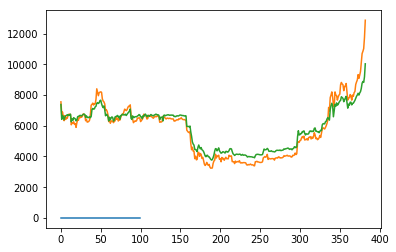

In [116]:
def main():
    raw_price_data = fetch_btc_prices()
    data_df = parse_alphaV_JSON(raw_data=raw_price_data)
    #print(data_df)
    data_df = data_df.iloc[::-1]
    #print(data_df)
    
    prices = np.array(data_df['4a. close (USD)'].tolist())
    print(prices)
    # -- Normalize the Data --
    min_max_scaler = preprocessing.MinMaxScaler()
    data_df = pd.DataFrame(min_max_scaler.fit_transform(data_df), columns=data_df.columns)
    # print(data_df)
    data_df = table_edit(data_df)
    y_train = np.array(data_df['4a. close (USD)'].tolist())
    data_df = data_df.drop(labels=['4a. close (USD)'],axis=1)
    model = MLP()
    losses, test_data_loader, loss_func, model, min_price, max_price, test_prices = train(model, data_df.values,y_train,prices)
    loss_visualize(losses)
    _, _, all_unnormed_outputs = validation_test(test_dataloader=test_data_loader,criterion=loss_func, model=model, norm_min=min_price, norm_max=max_price)
    
    prediction_visualization(minimum_price=min_price,maximum_price=max_price,close_prices=test_prices,model_predictions=all_unnormed_outputs)
    pass

main()